# ***3Δ ΥΠΟΛΟΓΙΣΤΙΚΗ ΓΕΩΜΕΤΡΙΑ ΚΑΙ ΟΡΑΣΗ***
## ΑΠΑΛΛΑΚΤΙΚΗ ΕΡΓΑΣΙΑ 4
### **Camera vs Lidar**

#### **ΟΝΟΜΑΤΕΠΩΝΥΜΟ:** ΚΩΝΣΤΑΝΤΟΥΡΑΣ ΓΕΩΡΓΙΟΣ
#### **ΑΡΙΘΜΟΣ ΜΗΤΡΩΟΥ:** 1092678
#### **ΕΤΟΣ:** 4ᵒ

Στόχος της εργασίας είναι να συγκριθούν τεχνικές ανίχνευσης δρόμου και εμποδίων χρησιμοποιώντας δεδομένα κάμερας και αισθητήρα Lidar από το KITTI dataset.

Το dataset μπορεί να βρεθεί στον παρακάτω σύνδεσμο:
https://www.cvlibs.net/datasets/kitti/eval_road.php

Θα αναλυθούν:

## Μέρος Α

### Εισαγωγή βιβλιοθηκών

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from ultralytics import YOLO
from sklearn.decomposition import PCA

# Κλάση ***RoadSegmenter***

In [2]:
class RoadSegmenter:
    def __init__(self, path):
        self.path = path
        self.image = None
        self.gray = None
        self.midline_x = None
        self.result = None

    def load_images(self):
        self.image = cv2.imread(self.path)

        if self.image is None:
            raise ValueError("Could not load the image.")

        # Convert to grayscale
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        # self.gray = clahe.apply(self.gray)
    
    def detect_edges(self):
        blurred = cv2.GaussianBlur(self.gray, (5, 5), 5)
        self.edges = cv2.Canny(blurred, 100, 180)

    def region_grow(self):
        height, width = self.gray.shape
        seed_point = (width // 2, height - 30)
        cv2.circle(self.image, seed_point, 5, (0, 255, 255), -1)

        mask = np.zeros((height + 2, width + 2), np.uint8)
        flooded = self.gray.copy()
        cv2.floodFill(flooded, mask, seed_point, 125, loDiff=5, upDiff=5, flags=8)
        self.region = mask[1:-1, 1:-1]
        
        # Cut 40 % of top of the image
        cutoff_row = int(height * 0.4)
        self.region[:cutoff_row, :] = 0
        
        self.filled_region = cv2.morphologyEx(self.region, cv2.MORPH_CLOSE, np.ones((6, 6), np.uint8))

    def colorize_lanes(self, alpha=0.2):
        road_mask = self.filled_region.astype(np.uint8) * 255
        height, width = road_mask.shape
        midline = np.zeros_like(road_mask)
        left_mask = np.zeros_like(road_mask)
        right_mask = np.zeros_like(road_mask)

        mid_x_vals = []

        for y in range(height):
            x_coords = np.where(road_mask[y] == 255)[0]
            if len(x_coords) > 1:
                x_left = x_coords[0]
                x_right = x_coords[-1]
                x_mid = (x_left + x_right) // 2
                mid_x_vals.append(x_mid)
            else:
                mid_x_vals.append(-1)

        # Savitzky-Golay
        mid_x_vals = np.array(mid_x_vals)
        valid_indices = np.where(mid_x_vals != -1)[0]
        smoothed = mid_x_vals.copy()
        if len(valid_indices) > 5:
            smoothed[valid_indices] = savgol_filter(mid_x_vals[valid_indices], window_length=21, polyorder=2)

        for i, x in enumerate(smoothed):
            if x != -1:
                x = int(x)
                midline[i, x] = 255
                for j in np.where(road_mask[i] == 255)[0]:
                    if j < x:
                        left_mask[i, j] = 1
                    elif j > x:
                        right_mask[i, j] = 1

        # Overlay image
        overlay = np.zeros_like(self.image, dtype=np.uint8)

        # Color the lanes
        overlay[road_mask == 0] = [255, 0, 0]
        overlay[(road_mask == 255) & (left_mask == 1)] = [0, 255, 0]
        overlay[(road_mask == 255) & (right_mask == 1)] = [0, 0, 255]
        overlay[midline == 255] = [255, 255, 255]

        self.result = cv2.addWeighted(self.image, 1 - alpha, overlay, alpha, 0)

    def detect_obstacles(self, model_path="yolov8n.pt", conf_threshold=0.3):
        # Load YOLO model
        model = YOLO(model_path)

        # Detect objects in the image
        results = model(self.image)[0]
        self.obstacles = []

        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            conf = float(box.conf)
            if conf < conf_threshold:
                continue

            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(self.filled_region.shape[1] - 1, x2)
            y2 = min(self.filled_region.shape[0] - 1, y2)

            obj_mask = self.filled_region[y1:y2, x1:x2]
            if np.any(obj_mask > 0):
                self.obstacles.append((x1, y1, x2, y2))

                cv2.rectangle(self.result, (x1, y1), (x2, y2), (0, 255, 255), 2)

        print(f"Found {len(self.obstacles)} obstacles intersecting the road.")

    def compute_motion_vector_pca(self):
        height, width = self.filled_region.shape
        mid_points = []

        for y in range(height - 1, 0, -1):
            x_vals = np.where(self.filled_region[y] == 1)[0]
            if len(x_vals) > 1:
                x_mid = (x_vals[0] + x_vals[-1]) // 2
                mid_points.append([x_mid, y])

        if len(mid_points) < 2:
            print("Not enough midline points for PCA.")
            return

        mid_points = np.array(mid_points)

        # PCA
        pca = PCA(n_components=2)
        pca.fit(mid_points)
        direction = pca.components_[0]

        if direction[1] > 0:
            direction = -direction

        center = np.mean(mid_points, axis=0).astype(int)
        
        if len(self.obstacles) == 0:
            scale = 100
            end_point = (int(center[0] + scale * direction[0]), int(center[1] + scale * direction[1]))
            cv2.arrowedLine(self.result, tuple(center), end_point, (255, 255, 255), 3, tipLength=0.2)
        else:
            cv2.circle(self.result, tuple(center), 30, (0, 0, 255), thickness=3)
            cv2.putText(self.result, "Obstacle Ahead", (center[0] - 50, center[1] - 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv2.LINE_AA)

        print(f"Midline PCA vector: {direction}")

    def show_results(self):
        fig, axes = plt.subplots(3, 1, figsize=(8, 15))
    
        # Original Image
        axes[0].imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
        axes[0].axis('off')
    
        # Segmented Region
        axes[1].imshow(self.filled_region, cmap='gray')
        axes[1].set_title("Segmented Road Region", fontsize=14, fontweight='bold')
        axes[1].axis('off')
    
        # Final result
        axes[2].imshow(cv2.cvtColor(self.result, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Detected Lanes", fontsize=14, fontweight='bold')
        axes[2].axis('off')
    
        plt.tight_layout()
        plt.show()

    def save_results(self, path):
        # Save Result
        save_dir = "saved_images/partA"
        os.makedirs(save_dir, exist_ok=True)

        base_name = os.path.basename(path)
        save_path = os.path.join(save_dir, base_name)

        cv2.imwrite(save_path, self.result)
        print(f"Image saved as: {save_path}")

    def run(self):
        # Load Both Left and Right Images and convert to grayscale
        self.load_images()
        # a) Using growing region
        self.detect_edges()
        self.region_grow()
        self.colorize_lanes()
        
        # b) Detect obstacles using YOLO
        self.detect_obstacles()
        
        # c) Compute motion vector using PCA
        self.compute_motion_vector_pca()
        
        self.show_results()
    


# **Καθορισμός διαδρομών των εικόνων (path)**

In [44]:
path = "image_2/um_000000.png"

In [20]:
path = "road_with_wall/um_000000.png"

# Δημιουργία Αντικειμένου segmenter τύπου RoadSegmenter

In [45]:
segmenter = RoadSegmenter(path)

In [46]:
segmenter.load_images()

In [47]:
segmenter.detect_edges()
segmenter.region_grow()
segmenter.colorize_lanes()

In [48]:
segmenter.detect_obstacles()


0: 224x640 1 person, 1 bicycle, 54.0ms
Speed: 3.0ms preprocess, 54.0ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)
Found 0 obstacles intersecting the road.


In [49]:
segmenter.compute_motion_vector_pca()

Midline PCA vector: [   0.076114     -0.9971]


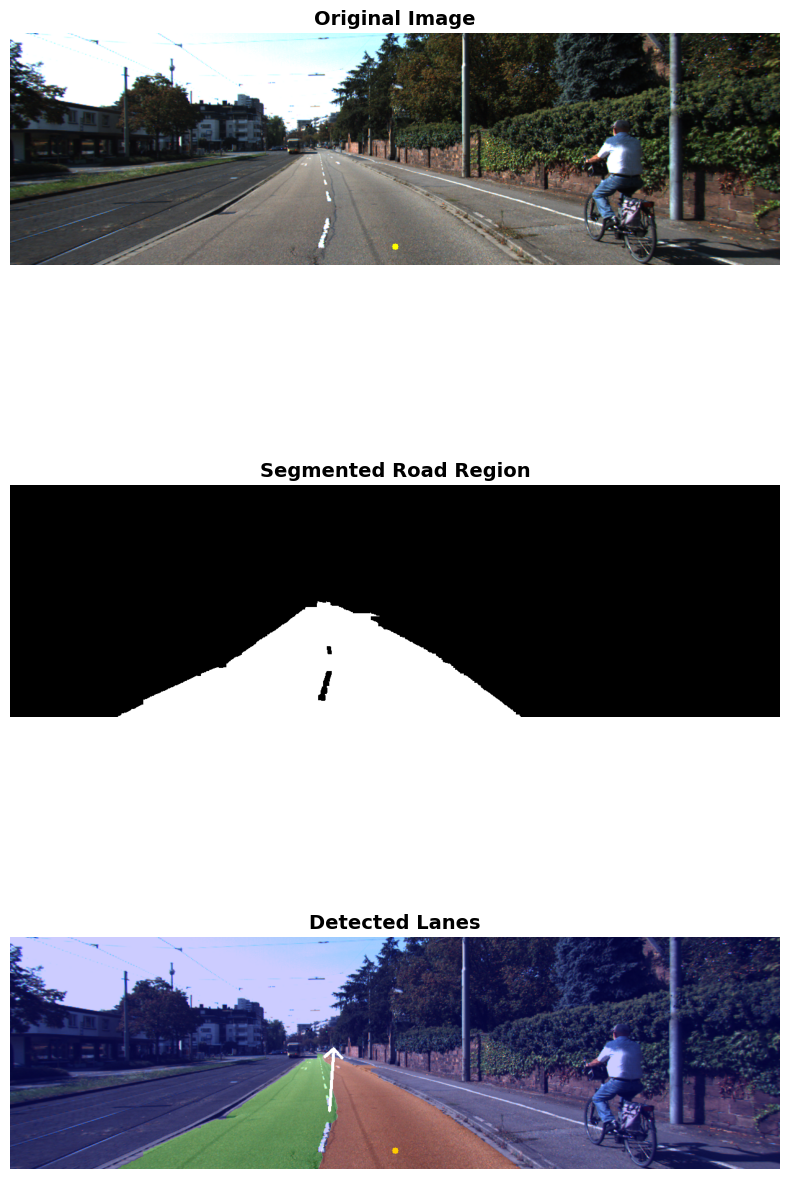

In [50]:
segmenter.show_results()

In [51]:
segmenter.save_results(path)

Image saved as: saved_images/partA\um_000000.png


# Δημιουργία gif για απεικόνιση των λύσεων για διαδοχικά καρέ

In [28]:
import imageio.v2 as imageio
import cv2
import os

In [29]:
def create_gif_from_images(image_paths, output_path="road_animation.gif", fps=1):
    frames = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Image not found: {path}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        frames.append(img_rgb)
    
    if frames:
        imageio.mimsave(output_path, frames, fps=fps, loop=0)
        print(f"GIF saved as: {output_path}")
    else:
        print("No image loaded.")

In [52]:
image_paths = [
    "saved_images/partA/um_000000.png",
    "saved_images/partA/um_000001.png",
    "saved_images/partA/um_000002.png",
    "saved_images/partA/um_000003.png"
]

In [54]:
image_paths = [
    "saved_images/partA/road_with_walls/um_000000.png",
    "saved_images/partA/road_with_walls/um_000001.png",
    "saved_images/partA/road_with_walls/um_000002.png"
]

In [53]:
create_gif_from_images(image_paths, output_path="road_animation.gif", fps=1.0)

GIF saved as: road_animation.gif


In [55]:
create_gif_from_images(image_paths, output_path="road_animation_with_walls.gif", fps=1.0)

GIF saved as: road_animation_with_walls.gif


# Μέρος Β - Lidar

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import open3d as o3d
from sklearn.neighbors import KDTree

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class RoadSegmenter:
    def __init__(self, img_path, lidar_path, calib_path):
        self.image = self.load_image(img_path)
        self.lidar_points = self.load_lidar_points(lidar_path)
        self.road_points = np.empty((0, 3))
        self.P2, self.R0, self.Tr = self.load_calibration_file(calib_path)

    def load_image(self, path):
        image = cv2.imread(path)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def load_lidar_points(self, path):
        scan = np.fromfile(path, dtype=np.float32).reshape(-1, 4)
        return scan[:, :3]

    def load_calibration_file(self, filepath):
        calib = {}
        with open(filepath) as f:
            for line in f:
                if ":" in line:
                    key, value = line.strip().split(":", 1)
                    calib[key] = np.array([float(x) for x in value.strip().split()])
        return (
            calib["P2"].reshape(3, 4),
            calib["R0_rect"].reshape(3, 3),
            calib["Tr_velo_to_cam"].reshape(3, 4),
        )

    def project_points_to_image(self, points, return_mask=False):
        N = points.shape[0]
        points_hom = np.hstack((points, np.ones((N, 1))))
        cam_points = self.Tr @ points_hom.T
        cam_points = self.R0 @ cam_points[:3, :]
        valid = cam_points[2, :] > 0
        cam_points = cam_points[:, valid]
        proj = self.P2 @ np.vstack((cam_points, np.ones((1, cam_points.shape[1]))))
        proj = proj[:2, :] / proj[2, :]
        if return_mask:
            return proj.T.astype(int), valid
        else:
            return proj.T.astype(int)

    @staticmethod
    def compute_saliency(points, k=30):
        saliency = np.zeros(len(points))
        tree = KDTree(points)

        for i in range(len(points)):
            idxs = tree.query(points[i : i + 1], k=k, return_distance=False)[0]
            local_pts = points[idxs]

            # Fast PCA with NumPy
            local_pts_centered = local_pts - np.mean(local_pts, axis=0)
            try:
                _, s, _ = np.linalg.svd(local_pts_centered, full_matrices=False)
                saliency[i] = s[-1] / np.sum(s) if np.sum(s) != 0 else 1.0
            except:
                saliency[i] = 1.0

        return saliency

    @staticmethod
    def filter_ground_points(
        points, z_range=(-2.2, -1.3), y_limit=10.0, x_range=(0, 25)
    ):
        return points[
            (points[:, 0] > x_range[0])
            & (points[:, 0] < x_range[1])
            & (points[:, 1] > -y_limit)
            & (points[:, 1] < y_limit)
            & (points[:, 2] > z_range[0])
            & (points[:, 2] < z_range[1])
        ]

    def filter_by_saliency(self, points, k=50, percentile=10):
        saliency = self.compute_saliency(points, k=k)
        threshold = np.percentile(saliency, percentile)
        return points[saliency < threshold]

    @staticmethod
    def select_pixel_cluster(points, labels, pixel_coords, seed_pixel):
        if len(labels) == 0 or np.all(labels == -1):
            return np.empty((0, 3))
        distances = np.linalg.norm(pixel_coords - np.array(seed_pixel), axis=1)
        seed_label = labels[np.argmin(distances)]
        return points[labels == seed_label]

    def detect_road(
        self,
        ground_points,
        seed_pixel,
        saliency_k=35,
        saliency_thresh=25,
        eps=20.0,
        min_samples=10,
    ):
        road_candidates = self.filter_by_saliency(
            ground_points, k=saliency_k, percentile=saliency_thresh
        )
        proj_pixels, valid_mask = self.project_points_to_image(
            road_candidates, return_mask=True
        )
        road_candidates = road_candidates[valid_mask]
        proj_pixels = self.project_points_to_image(road_candidates)
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(proj_pixels)
        return self.select_pixel_cluster(
            road_candidates, labels, proj_pixels, seed_pixel
        )

    @staticmethod
    def estimate_motion_vector(road_points):
        pca = PCA(n_components=3)
        pca.fit(road_points)
        direction = pca.components_[0]
        return direction / np.linalg.norm(direction)

    def visualize_projection(self, image, proj_points, color=(0, 255, 0), alpha=0.2):
        overlay = image.copy()
        h, w = image.shape[:2]

        # Φιλτράρισμα σημείων που είναι μέσα στην εικόνα
        proj_points = np.array(
            [pt for pt in proj_points if 0 <= pt[0] < w and 0 <= pt[1] < h]
        )
        if len(proj_points) < 3:
            return overlay

        # Δημιουργία αρχικής μάσκας με γεμίσματα γύρω από τα σημεία
        mask = np.zeros((h, w), dtype=np.uint8)
        for x, y in proj_points.astype(np.int32):
            cv2.circle(mask, (x, y), radius=5, color=255, thickness=-1)

        # Κλείσιμο για να ενωθούν περιοχές
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)

        # Εξομάλυνση για πιο ομαλό περίγραμμα
        mask = cv2.GaussianBlur(mask, (5, 5), 0)

        # Εύρεση εξωτερικών περιγραμμάτων
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        simplified_contours = [
            cv2.approxPolyDP(cnt, epsilon=2.0, closed=True) for cnt in contours
        ]

        # Γέμισμα των εξωτερικών περιγραμμάτων
        filled_mask = np.zeros_like(image, dtype=np.uint8)
        cv2.drawContours(
            filled_mask, simplified_contours, -1, color, thickness=cv2.FILLED
        )

        # Ανάμειξη με την εικόνα
        blended = cv2.addWeighted(filled_mask, alpha, overlay, 1, 0)

        # Αποθήκευση μάσκας δρόμου για χρήση στον έλεγχο εμποδίων
        self.road_mask = mask

        return blended

    def points_within_road(self, lidar_points, road_points, margin=0.5):
        x_min, x_max = np.min(road_points[:, 0]), np.max(road_points[:, 0])
        y_min, y_max = np.min(road_points[:, 1]), np.max(road_points[:, 1])

        return lidar_points[
            (lidar_points[:, 0] >= x_min - margin) &
            (lidar_points[:, 0] <= x_max + margin) &
            (lidar_points[:, 1] >= y_min - margin) &
            (lidar_points[:, 1] <= y_max + margin)
        ]


    def detect_obstacles(self, lidar_points, road_points,
                                xy_margin=0.3, z_threshold=0.25):
        if len(road_points) == 0:
            return np.empty((0, 3))

        # 1. XY όρια του δρόμου (με λίγο περιθώριο)
        x_min, x_max = np.min(road_points[:, 0]) - xy_margin, np.max(road_points[:, 0]) + xy_margin
        y_min, y_max = np.min(road_points[:, 1]) - xy_margin, np.max(road_points[:, 1]) + xy_margin

        # 2. Φιλτράρισμα LiDAR σημείων εντός του XY ορίου
        in_road_xy = lidar_points[
            (lidar_points[:, 0] >= x_min) & (lidar_points[:, 0] <= x_max) &
            (lidar_points[:, 1] >= y_min) & (lidar_points[:, 1] <= y_max)
        ]

        if len(in_road_xy) == 0:
            return np.empty((0, 3))

        # 3. Υπολογισμός μέσου ύψους του δρόμου
        road_z_mean = np.mean(road_points[:, 2])

        # 4. Επιστροφή μόνο των σημείων που είναι πάνω από τον δρόμο κατά z_threshold
        mask = in_road_xy[:, 2] > road_z_mean + z_threshold
        return in_road_xy[mask]



    def draw_obstacles(self, image, obstacles, color=(255, 0, 0)):
        proj, valid = self.project_points_to_image(obstacles, return_mask=True)
        proj = proj[valid]
        for pt in proj:
            cv2.circle(image, tuple(pt), 3, color, -1)
        return image

    def run(self, seed_pixel=(580, 300)):
        # 1. Φιλτράρουμε τα ground points
        ground_points = self.filter_ground_points(self.lidar_points)

        # 2. Ανίχνευση δρόμου με χρήση seed
        road_points = self.detect_road(ground_points, seed_pixel)
        self.road_points = road_points

        # 3. Προβολή του δρόμου πάνω στην εικόνα
        proj_road = self.project_points_to_image(road_points)
        overlay = self.visualize_projection(self.image, proj_road, color=(0, 255, 0))

        # 4. Ανίχνευση εμποδίων αυστηρά πάνω από τον δρόμο
        obstacle_candidates = self.detect_obstacles(self.lidar_points, road_points,
                                                        xy_margin=0.1, z_threshold=0.3)


        # 5. Clustering με DBSCAN
        if len(obstacle_candidates) > 0:
            labels = DBSCAN(eps=1.0, min_samples=10).fit_predict(obstacle_candidates[:, :3])
            obstacles = obstacle_candidates[labels != -1]
        else:
            obstacles = np.empty((0, 3))

        # 6. Προβολή εμποδίων
        overlay = self.draw_obstacles(overlay, obstacles)

        if len(obstacles) > 0:
            h, w = overlay.shape[:2]
            center = (w // 2, h // 2)
            cv2.circle(overlay, center, 30, (0, 0, 255), thickness=3)
            cv2.putText(
                overlay,
                "Obstacle Ahead",
                (center[0] - 50, center[1] - 40),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 0, 255),
                2,
            )
        else:
            direction = self.estimate_motion_vector(road_points)
            origin = np.mean(road_points, axis=0)
            end_point = origin + direction * 5.0
            vector_points = np.vstack([origin, end_point])
            proj_vector = self.project_points_to_image(vector_points)
            cv2.arrowedLine(
                overlay,
                tuple(proj_vector[0]),
                tuple(proj_vector[1]),
                (0, 0, 255),
                4,
                tipLength=0.2,
            )
        self.overlay = overlay
        plt.figure(figsize=(12, 6))
        plt.imshow(overlay)
        plt.title("Road and Obstacles Detection")
        plt.axis("off")
        plt.show()

    def save_results(self, path):
        # Save Result
        save_dir = "saved_images/partB"
        os.makedirs(save_dir, exist_ok=True)

        base_name = os.path.basename(path)
        save_path = os.path.join(save_dir, base_name)
        
        bgr_overlay = cv2.cvtColor(self.overlay, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, bgr_overlay)
        print(f"Image saved as: {save_path}")


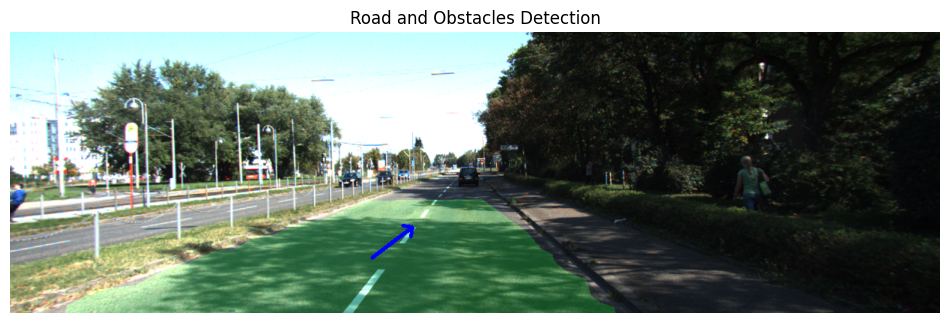

In [3]:
i = "um_000021"
j = f"{i}_with_wall"
path=f"image_2/{i}.png"
segmenter_lidar = RoadSegmenter(
    img_path=f"image_2/{i}.png",
    lidar_path=f"training/velodyne/{i}.bin",
    calib_path=f"calib/{i}.txt",
)
segmenter_lidar.run()

In [4]:
segmenter_lidar.save_results(path)

Image saved as: saved_images/partB\um_000021.png
